<a href="https://colab.research.google.com/github/deepakgarg08/llm-diary/blob/main/llm_chronicles_6_3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Chronicles: OpenAI CLIP for image classification and similarity

This notebook demonstrates how to use the OpenAI CLIP model for zero-shot image classification and image similarity. We will explore loading CLIP from HuggingFace and deploying it with Azure AI Studio.

**CLIP (Contrastive Language–Image Pre-training)** is a powerful model that can associate images with text without any direct training for specific tasks. For more details, see the original CLIP paper by Radford et al. (2021): https://arxiv.org/abs/2103.00020.

Check out the episode on Multi-Modal LLMs: https://youtu.be/_sGwL6RAsUc.

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/clip.png)

# 1 - Imports and Model Loading

In [ ]:
from PIL import Image
import requests
import torch
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

torch.set_printoptions(sci_mode=False)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
import requests
from PIL import Image
from io import BytesIO

def load_image_from_url(url):
    try:
        # Get the image from the URL
        response = requests.get(url)
        response.raise_for_status()  # Check for HTTP errors

        # Open the image with PIL
        img = Image.open(BytesIO(response.content))
        return img

    except requests.exceptions.RequestException as e:
        print(f"Error loading image: {e}")
        return None

In [ ]:
import matplotlib.pyplot as plt
import math

def display_images(images):
    """
    Displays a list of images in a dynamically calculated grid with image titles, in a compact layout.
    """
    # Calculate the number of rows required
    num_images = len(images)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, image in enumerate(images):
        if image.mode == 'L':
            axes[idx].imshow(image, cmap='gray')
        else:
            axes[idx].imshow(image)
        axes[idx].set_title(f"Image {idx+1}")
        axes[idx].axis("off")
    plt.show()


#2 - Zero-shot classification

The following cell demonstrates zero-shot image classification using CLIP. We input text prompts and an image, and the model returns image-text similarity scores. By applying softmax to these scores, we obtain probabilities indicating how likely each text description matches the image.

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/clip-zeroshot.png)

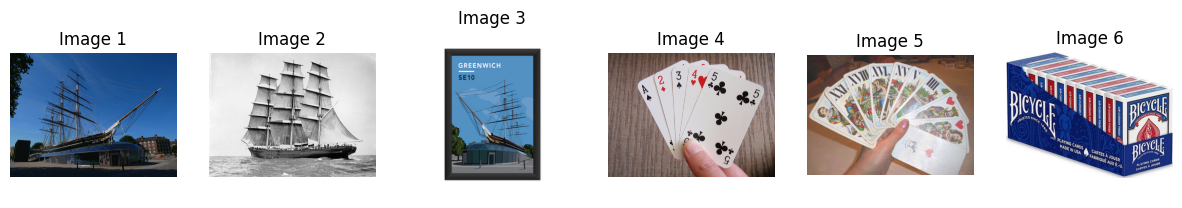

In [ ]:
import matplotlib.pyplot as plt

image1 = load_image_from_url("https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/cutty-sark-1.jpg")
image2 = load_image_from_url("https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/cutty-sark-2.jpg")
image3 = load_image_from_url("https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/cutty-sark-3.webp")
image4 = load_image_from_url("https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/cards-1.jpeg")
image5 = load_image_from_url("https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/cards-2.jpg")
image6 = load_image_from_url("https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/cards-3.webp")

# Store the images in a list
images = [image1, image2, image3, image4, image5, image6]

display_images(images)

In [ ]:
inputs = processor(
    text=["a ship", "a photo of a ship in a frame", "playing cards", "a fan of playing cards"],
    images=image4,
    return_tensors="pt",
    padding=True)

inputs

{'input_ids': tensor([[49406,   320,  1158, 49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406,   320,  1125,   539,   320,  1158,   530,   320,  6481, 49407],
        [49406,  1629,  4094, 49407, 49407, 49407, 49407, 49407, 49407, 49407],
        [49406,   320,  2261,   539,  1629,  4094, 49407, 49407, 49407, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]), 'pixel_values': tensor([[[[-0.4054, -0.4054, -0.4200,  ..., -0.2010, -0.0405, -0.0842],
          [-0.3762, -0.3324, -0.3324,  ..., -0.2302, -0.1426, -0.0405],
          [-0.3324, -0.4200, -0.4346,  ..., -0.1572, -0.1864, -0.0842],
          ...,
          [-0.0405, -0.0113, -0.0405,  ..., -1.2375, -1.0039, -0.9018],
          [-0.2594, -0.2740, -0.1718,  ..., -1.2083, -1.0769, -0.9018],
          [-0.2302, -0.2448, -0.0113,  ..., -1.1061, -1.0185, -0.7558]],

         [[-0.6865,

In [ ]:
inputs.pixel_values.shape

torch.Size([1, 3, 224, 224])

In [ ]:
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

probs

tensor([[    0.0001,     0.0000,     0.5836,     0.4163]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
inputs = processor(
    text=["a ship", "a photo of a ship in a frame", "playing cards", "a fan of playing cards"],
    images=images,
    return_tensors="pt",
    padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

probs

tensor([[    0.5556,     0.4441,     0.0001,     0.0001],
        [    0.2463,     0.7536,     0.0000,     0.0001],
        [    0.0430,     0.9556,     0.0011,     0.0003],
        [    0.0001,     0.0000,     0.5836,     0.4163],
        [    0.0001,     0.0000,     0.2050,     0.7948],
        [    0.0007,     0.0001,     0.7890,     0.2103]],
       grad_fn=<SoftmaxBackward0>)

#3 - Image Similarity

In this section, we compute image similarity by obtaining image embeddings from CLIP.

Instead of classifying images to labels, we preprocess images to get **pixel_values**, then use **get_image_features** to generate embeddings.

The **cosine similarity** between these embeddings provides a similarity score between the two image:

![picture](https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/cosine-similarity.png)



In [ ]:
# Obtain image embeddings

image1_preprocess = processor(images=image1, return_tensors="pt")['pixel_values']
image1_embedding = model.get_image_features( image1_preprocess)

image2_preprocess = processor(images=image2, return_tensors="pt")['pixel_values']
image2_embedding = model.get_image_features( image2_preprocess)

image1_embedding.shape

torch.Size([1, 512])

In [ ]:
import torch

similarity_score = torch.nn.functional.cosine_similarity(image1_embedding, image2_embedding)
similarity_score

tensor([1.0000], grad_fn=<SumBackward1>)

In [ ]:
import pandas as pd
import seaborn as sns

def compute_similarity(images):
    embeddings = []

    with torch.no_grad():
        for image in images:
            preprocess = processor(images=image, return_tensors="pt")['pixel_values']
            embedding = model.get_image_features(preprocess)
            embeddings.append(embedding)

    num_images = len(images)
    similarity_matrix = torch.zeros((num_images, num_images))

    with torch.no_grad():
        for i in range(num_images):
            for j in range(num_images):
                similarity_matrix[i, j] = torch.nn.functional.cosine_similarity(embeddings[i], embeddings[j])

    similarity_matrix = similarity_matrix.detach().numpy()
    image_labels = [f"Image {i+1}" for i in range(num_images)]
    similarity_df = pd.DataFrame(similarity_matrix, index=image_labels, columns=image_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_df, annot=True, cmap='Greens', linewidths=.5, cbar_kws={'label': 'Similarity'})
    plt.title("Image Similarity Heatmap")
    plt.show()

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for idx, image in enumerate(images):
        if image.mode == 'L':
            axes[idx].imshow(image, cmap='gray')
        else:
            axes[idx].imshow(image)
        axes[idx].set_title(f"Image {idx+1}")
        axes[idx].axis("off")

    plt.show()

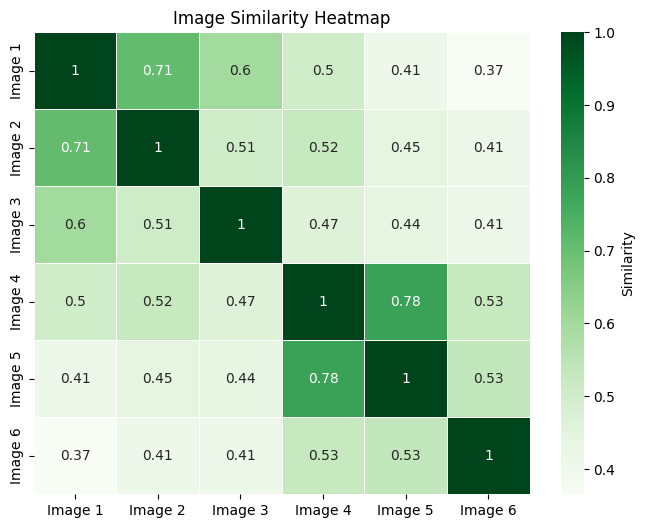

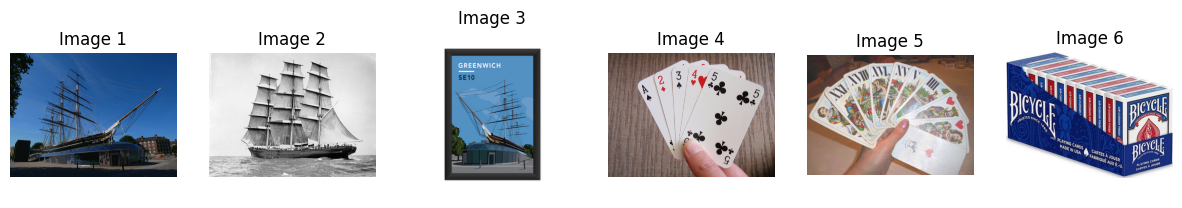

In [ ]:
compute_similarity(images)

#4 - Azure AI Studio

Azure AI Studio provides a model catalog (https://ai.azure.com/explore/models) with a large amounr of pre-trained models across different modalities. It allows you to deploy models easily, with some models available for serverless deployment, while others, like CLIP, require dedicated compute resources.

**Deployment Options**

The model catalog enables pay-as-you-go deployment for certain models. However, models like CLIP need dedicated infrastructure, so *it's important to delete resources after use to avoid ongoing charges for virtual machines*.

Once deployed, models can be accessed via Azure’s REST API for seamless integration into your applications.

In [ ]:
import base64
import requests

def image_to_base64(url):
    response = requests.get(url)
    return base64.b64encode(response.content).decode('utf-8')

In [ ]:
import urllib.request
import json
import os
import ssl
from google.colab import userdata

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

# Request data goes here
# The example below assumes JSON formatting which may be updated
# depending on the format your endpoint expects.
# More information can be found here:
# https://docs.microsoft.com/azure/machine-learning/how-to-deploy-advanced-entry-script
data = {
  "input_data": {
    "data": [
      [
        image_to_base64("https://raw.githubusercontent.com/kyuz0/llm-chronicles/main/6.3/cutty-sark-1.jpg"),
        "a ship, a photo of a ship in a frame, playing cards, a fan of playing cards"
      ]
    ],
    "columns": [
      "image",
      "text"
    ],
    "index": [
      0
    ]
  }
}

body = str.encode(json.dumps(data))

url = 'https://donatocapitella-5876-spzkb.eastus.inference.ml.azure.com/score'
# Replace this with the primary/secondary key, AMLToken, or Microsoft Entra ID token for the endpoint
api_key = ''
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(error.read().decode("utf8", 'ignore'))


b'[{"probs": [0.5555867552757263, 0.4441460967063904, 0.00013270833005663007, 0.00013438731548376381], "labels": ["a ship", "a photo of a ship in a frame", "playing cards", "a fan of playing cards"]}]'
